<a href="https://colab.research.google.com/github/NikaMasa51/hands-on_DL_230627/blob/main/codes/weed_classification_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

weed_classification_01  
Masanori Ishii & Wei Guo  
2022.08.26

# Build a Weed Discriminator by image clasification model  
  We prepared a weed dataset that include 10 species of weeds  

雑草の生育期間を区別せずに分類器を作る（10種類）  
　雑草の生育期間（芽生え・生育済み）を区別せずに分類器を作成します。 育成した雑草の種類はハキダメギク、ホソアオゲイトウ、イチビ、イヌビエ、コセンダングサ、マメアサガオ、メヒシバ、オヒシバ、オイヌタデ、シロザの10種類です

### Download the Dataset
データのダウンロード

download weeds_1.zip

In [ ]:
import gdown
# weeds_1
url = "https://drive.google.com/file/d/1w8UOD_vFWEzL3MYr4Gl1oF-Fiy7iklUW/view?usp=sharing"
output= "weeds_1.zip"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

weeds_1.zipを解凍します

In [ ]:
!unzip weeds_1.zip
print("unzip weeds")

### Prepare the dataset
データセットの準備

Display the images of weeds dataset  ("sprout", "grown")  
データセットの画像を表示します（芽生え・生育済み）

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

def show_img():
  #　雑草名と生育状態をリストに定義
  # weed_names = os.listdir('weeds_1/')
  # weed_types = os.listdir(os.path.join('weeds_1/', weed_names[0]))
  weed_names = ["hakidamegiku","hosoaogeitou","ichibi","inubie","kosendangusa","mameasagao","mehishiba","ohishiba","oinutade","shiroza"]
  weed_types = ["sprout", "grown"]

  #　データ格納フォルダを指定
  input_dir = "./weeds_1"

  #　リストの長さを足して表示枚数を確認
  hs = len(weed_names)*len(weed_types)

  #　表示設定
  col=len(weed_names)
  row=int(hs/col)
  cols=col*4
  rows=row*4
  dpis = 100

  #　イメージの表示サイズ、解像度
  fig = plt.figure(figsize=(cols,rows),dpi=dpis)

  #　＊＊番目に指定
  pi=1

  #　イメージ表示
  for weed_name in weed_names:
    #　1段目
    img_path = os.path.join(input_dir, weed_name, weed_types[0])
    img_list = os.listdir(img_path)
    plot_num = pi
    ax=fig.add_subplot(row, col, plot_num)
    ax.set_title(weed_name, fontsize=20)
    if plot_num == 1:
      plt.ylabel(weed_types[0], fontsize=20) # y軸ラベル
    img = Image.open(os.path.join(img_path, img_list[6])) # indexを変更して別の画像を表示！！
    plt.xticks(color="None")
    plt.yticks(color="None")
    plt.tick_params(length=0)
    plt.imshow(img, cmap='gray')
  #　2段目
    img_path = os.path.join(input_dir, weed_name, weed_types[1])
    img_list = os.listdir(img_path)
    plot_num2 = pi+10
    bx=fig.add_subplot(row, col, plot_num2)
    bx.set_title(weed_name, fontsize=20, pad=0)
    if plot_num2 == 11:
      plt.ylabel(weed_types[1], fontsize=20) # y軸ラベル
    img2 = Image.open(os.path.join(img_path, img_list[2]))
    plt.xticks(color="None")
    plt.yticks(color="None")
    plt.tick_params(length=0)
    plt.imshow(img2, cmap='gray')
    pi = pi+1
  fig.align_labels()

show_img()

Generate the directory of train、validation、prediction  
train、validation、prediction用のディレクトリを作成し、class用のディレクトリを追加します

In [ ]:
# debug use
# import shutil
# shutil.rmtree('CLS/', ignore_errors=True)

In [ ]:
import os, shutil

# make directory CLS
base_dir = "./CLS"
if "CLS" not in os.listdir("./"):
  os.mkdir(base_dir)
else:
  print(base_dir, "already exists")

# make directory train
train_index = "train"
train_dir = os.path.join(base_dir, train_index)
if train_index not in os.listdir(base_dir):
  os.mkdir(train_dir)
else:
  print(train_dir + "already exists")

# make directory validation
validation_index = "validation"
validation_dir = os.path.join(base_dir, validation_index)
if validation_index not in os.listdir(base_dir):
  os.mkdir(validation_dir)
else:
  print(validation_dir + "already exists")

# make directory prediction
prediction_index = "prediction"
prediction_dir = os.path.join(base_dir, prediction_index)
if prediction_index not in os.listdir(base_dir):
  os.mkdir(prediction_dir)
else:
  print(prediction_dir + "already exists")

# make directory class
# weed_names = os.listdir('weeds_1/')
# weed_types = os.listdir(os.path.join('weeds_1/', weed_names[0]))
# classes=weed_names
weed_names = ["hakidamegiku","hosoaogeitou","ichibi","inubie","kosendangusa","mameasagao","mehishiba","ohishiba","oinutade","shiroza"]
weed_types = ["sprout", "grown"]
classes=["hakidamegiku","hosoaogeitou","ichibi",
         "inubie","kosendangusa","mameasagao",
         "mehishiba","ohishiba","oinutade","shiroza",]
dirs = os.listdir(base_dir)
for dir in dirs:
  for cls in classes:
    # Directory with our training pictures
    class_dir = os.path.join(base_dir, dir, cls)
    if cls not in os.listdir(base_dir + "/" + dir):
      os.mkdir(class_dir)
    else:
      print(class_dir, "already exists")

print("finished make directory")

Split images to directory  
画像をディレクトリに振り分けます

In [ ]:
import numpy as np
from os.path import join
clsdir = "./weeds_1"
base_dir = "./CLS"
#weed_names = ["hakidamegiku","hosoaogeitou","ichibi","inubie","kosendangusa","mameasagao","mehishiba","ohishiba","oinutade","shiroza"]
#weed_types = ["sprout", "grown"]
rads=np.arange(0,200)
np.random.shuffle(rads)
#print(rads)
train_idx, val_idx,test_idx=np.split(rads, [int(.7 * len(rads)), int(.9 * len(rads))])
for weed_name in weed_names:
  for weed_type in weed_types:
    file_names = os.listdir(os.path.join(clsdir, weed_name, weed_type))
    for idx in train_idx:
        # 移動元のファイル
        path1 = os.path.join(clsdir, weed_name, weed_type, file_names[idx])
        # 移動先のファイル
        path2= os.path.join(base_dir, "train", weed_name, file_names[idx])
        # ファイルを移動
        new_path = shutil.copy(path1, path2)
        #print('copied training data')
    for idx in val_idx:
        # 移動元のファイル
        path1 = os.path.join(clsdir, weed_name, weed_type, file_names[idx])
        # 移動先のファイル
        path2= os.path.join(base_dir, "validation", weed_name, file_names[idx])
        # ファイルを移動
        new_path = shutil.copy(path1, path2)
        #print('copied vilidation data')
    for idx in test_idx:
        # 移動元のファイル
        path1 = os.path.join(clsdir, weed_name, weed_type, file_names[idx])
        # 移動先のファイル
        path2= os.path.join(base_dir, "prediction", weed_name, file_names[idx])
        # ファイルを移動
        new_path = shutil.copy(path1, path2)
        #print('copied test data')
print('finished copy')

In [ ]:
train_nums=len(os.listdir('CLS/train/ichibi'))
print('number of train image',train_nums)
val_nums=len(os.listdir('CLS/validation/ichibi'))
print('number of train image',val_nums)
test_nums=len(os.listdir('CLS/prediction/ichibi'))
print('number of test image',test_nums)

・trainデータ、validationデータ、predictionデータのgeneratorを作成します

In [ ]:
import os
import numpy as np
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image as Image

input_size = 224

train_dir = "./CLS/train"
validation_dir = "./CLS/validation"


train_datagen = Image.ImageDataGenerator(
            featurewise_center = False,
            samplewise_center = False,
            featurewise_std_normalization = False,
            samplewise_std_normalization = False,
            zca_whitening = False,
            rotation_range = 90,
            width_shift_range = 0.3,
            height_shift_range = 0.3,
            horizontal_flip = True,
            vertical_flip = False,
            rescale=1./255
        )

val_datagen = Image.ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(input_size,input_size),
            batch_size=10,
            class_mode='categorical'
        )

validation_generator = val_datagen.flow_from_directory(
            validation_dir,
            target_size=(input_size,input_size),
            batch_size=10,
            class_mode='categorical'
        )
print("dataset prepared")

### Model Training
トレーニングの実行

Defome model layers  
モデルのレイヤー構成を定義します

In [ ]:

#ファインチューニング+VGG+水増し。ここから実行してOK（VGG16をダウンロード）
from keras import models
from keras import layers
from keras.optimizers import adam_v2
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.applications.vgg16 import VGG16
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History, Callback
# from keras.objectives import categorical_crossentropy
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from scipy.stats import mode
import os, pickle

def create_cnn():
  input_size=224
  #input_sizeは224,224までOK。

  vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(input_size,input_size, 3))
  last = vgg_conv.output

  vgg_conv.trainable = True

  set_trainable = False
  for layer in vgg_conv.layers:
    if layer.name == 'block5_conv1':
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

  mod = Flatten()(last)
  mod = Dense(256, activation='relu')(mod)
  #mod = Dropout(0.5)(mod)
  preds = Dense(10, activation='softmax')(mod)

  model = models.Model(vgg_conv.input, preds)

  return model
print("Layer defined！")
print("レイヤー構成を定義しました！")

Define check point (save the weight when reach to best val loss )  
チェックポイントを定義します(val lossが一番低い値の時にweightファイルを保存)

In [ ]:
class Checkpoint(Callback):
    def __init__(self, model, filepath):
        self.model = model
        self.filepath = filepath
        self.best_val_acc = 0.0
        self.best_val_loss = 0.7

    def on_epoch_end(self, epoch, logs):
        # val_lossが最小の時ににweightを保存する
        if self.best_val_loss > logs["val_loss"]:
            self.model.save_weights(self.filepath)
            self.best_val_loss = logs["val_loss"]
            print("Weights saved.", self.best_val_loss)
print("Check point defined！")
print("チェックポイントを定義しました！")

Define training process  
学習の実行手順を定義します

In [ ]:
def train():
    print("start training")
    print("学習を開始します")
    hist = History()
    train_model = create_cnn()
    # train_model.compile(optimizer=adam_v2.Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    train_model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    cp = Checkpoint(train_model, f"weights.hdf5")
    train_model.fit_generator(train_generator,epochs=10,validation_data=validation_generator,callbacks=[hist, cp])
    print("finished training")
    print("学習が完了しました")
    return hist.history
print("training process defined")
print("実行手順を定義しました！")

Start training  
学習を開始します

In [ ]:
K.clear_session()
hist = train()

start training
学習を開始します


<ipython-input-13-5d881c1ffd16>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  train_model.fit_generator(train_generator,epochs=10,validation_data=validation_generator,callbacks=[hist, cp])


Epoch 1/10
280/280 [==============================] - 72s 217ms/step - loss: 1.7443 - accuracy: 0.3732 - val_loss: 1.0465 - val_accuracy: 0.6413
Epoch 2/10
280/280 [==============================] - 49s 174ms/step - loss: 0.9987 - accuracy: 0.6475 - val_loss: 0.6883 - val_accuracy: 0.7613
Epoch 3/10
280/280 [==============================] - 50s 178ms/step - loss: 0.7393 - accuracy: 0.7414 - val_loss: 0.5948 - val_accuracy: 0.7937
Epoch 4/10
280/280 [==============================] - 48s 170ms/step - loss: 0.6214 - accuracy: 0.7746 - val_loss: 0.4202 - val_accuracy: 0.8587
Epoch 5/10
280/280 [==============================] - 48s 172ms/step - loss: 0.5010 - accuracy: 0.8171 - val_loss: 0.3636 - val_accuracy: 0.8725
Epoch 6/10
280/280 [==============================] - 47s 168ms/step - loss: 0.4363 - accuracy: 0.8407 - val_loss: 0.4025 - val_accuracy: 0.8600
Epoch 7/10
280/280 [==============================] - 48s 170ms/step - loss: 0.4131 - accuracy: 0.8529 - val_loss: 0.3204 - val_ac

### Check Accuracy and Loss
正解率と損失率をグラフ化

accuracy and loss for Train and alidation  
trainの正解率と損失率、validationの正解率と損失率をグラフ化します

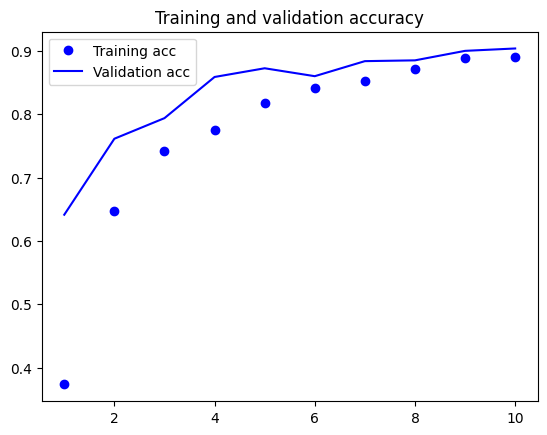

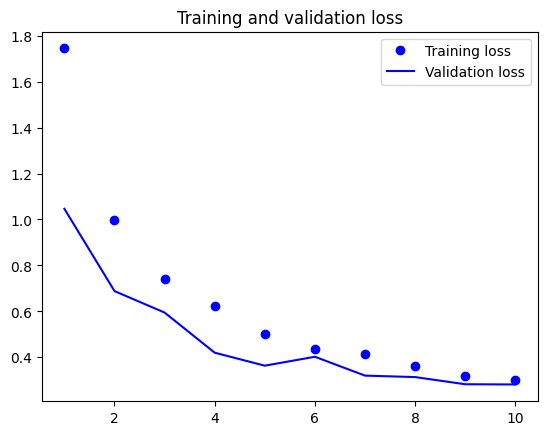

In [ ]:
import matplotlib.pyplot as plt

history = hist

acc=history['accuracy']
val_acc=history['val_accuracy']
loss=history['loss']
val_loss=history['val_loss']

epochs=range(1,len(acc)+1)

#正解率plot
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


#損失値をplot
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


### Test
テスト

prepared data for test(prediction)  
prediction用のデータセットを作成します

In [ ]:
from PIL import Image
import os, glob
import numpy as np
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES =True

prediction_dir = "./CLS/prediction"
prediction_classes = ["hakidamegiku","hosoaogeitou","ichibi","inubie","kosendangusa","mameasagao","mehishiba","ohishiba","oinutade","shiroza"]

image_size = 224
print(prediction_classes)
X_test = []
y_test = []
for index, classlabel in enumerate(prediction_classes):
    photos_dir = os.path.join(prediction_dir, classlabel)
    files = glob.glob(photos_dir + "/*.JPG")
    print(files)
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        if i == 0:
          print(data.shape)
        X_test.append(data)
        y_test.append(index)

X_test1 = np.array(X_test)
y_test1 = np.array(y_test)
print("prediction data prepared！")
print("predictionデータ作成完了！")

['hakidamegiku', 'hosoaogeitou', 'ichibi', 'inubie', 'kosendangusa', 'mameasagao', 'mehishiba', 'ohishiba', 'oinutade', 'shiroza']
['./CLS/prediction/hakidamegiku/hakidamegiku_IMG_1525_18.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1546_14.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1547_18.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1629_21.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1773_4.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1652_3.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1807_4.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1573_14.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1794_10.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1630_15.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1546_16.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_4464_6.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_4464_3.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_4468_4.JPG', './CLS

Function for Confusion Matrix  
混同行列(Confusion Matrix)表示用の関数を定義します

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=-90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print("function for confusion matrix")
print("混同行列表示用の関数を定義しました！")

function for confusion matrix
混同行列表示用の関数を定義しました！


load weight file for testing  
保存したweightファイルをロードしてテストを行います

In [ ]:
def sin_predict():
    X_test, y_test = X_test1, y_test1
    X_test = X_test / 255.0
    y_test_label = np.ravel(y_test)
    y_test = to_categorical(y_test)

    train_model = create_cnn()
    # train_model.compile(optimizer=adam_v2.Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    train_model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

    # 最良のモデルの読み込み
    train_model.load_weights(f"weights.hdf5")
    for layer in train_model.layers:
      layer.trainable = False

    # 単体のテスト
    single_pred = np.argmax(train_model.predict(X_test), axis=-1)

    # テストのスコア
    test_acc = accuracy_score(y_test, to_categorical(single_pred))

    print("test accuracy is", test_acc, )
    print("テストの結果は", test_acc, "です")

    target_names = ["hakidamegiku","hosoaogeitou","ichibi","inubie","kosendangusa","mameasagao","mehishiba","ohishiba","oinutade","shiroza"]
    cm = confusion_matrix(y_test_label, single_pred)
    plot_confusion_matrix(cm, classes = target_names)
print("function for testing use！")
print("テスト用の関数を定義しました！")

function for testing use！
テスト用の関数を定義しました！


13/13 [==============================] - 9s 329ms/step
test accuracy is 0.9075
テストの結果は 0.9075 です
Confusion matrix, without normalization


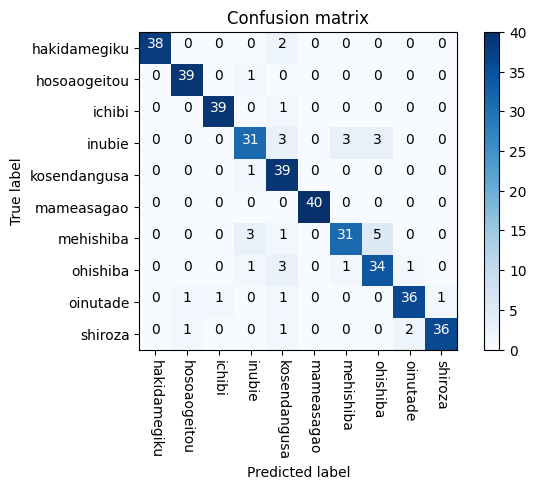

In [ ]:
# testing
sin_predict()

### Test on customized data  
任意の写真をテストします

function for test customized data  
画像テスト用の関数を定義します

In [ ]:
def result_predict(path):
    prediction_classes = ["hakidamegiku","hosoaogeitou","ichibi","inubie","kosendangusa","mameasagao","mehishiba","ohishiba","oinutade","shiroza"]

    train_model = create_cnn()
    # train_model.compile(optimizer=adam_v2.Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    train_model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

    # 最良のモデルの読み込み
    train_model.load_weights(f"weights.hdf5")
    for layer in train_model.layers:
        layer.trainable = False

    X_test = []
    image_size = 224
    image = Image.open(path)
    image = image.convert("RGB")
    image = image.resize((image_size, image_size))
    data = np.asarray(image)
    X_test.append(data)
    X_test = np.array(X_test) / 255.0
    result = np.argmax(train_model.predict(X_test), axis=-1)
    print("This picture is :", prediction_classes[result[0]])
    print("雑草の種類は :", prediction_classes[result[0]])
print("defined function for testing！")
print("画像テスト用の関数を定義しました！")

defined function for testing！
画像テスト用の関数を定義しました！


pick your own data and test  
there is a [question online](https://detail.chiebukuro.yahoo.co.jp/qa/question_detail/q13159032353), lets try to answer it   
predictionディレクトリから任意の写真を選択しpathを設定します

In [ ]:
!wget 'https://www.dropbox.com/s/cr4ldvg6gvlv2kz/kosendangusa.jpg'
patht1 = "/content/kosendangusa.jpg"
patht2= os.path.join(base_dir, "prediction", "kosendangusa", "kosendangusa.jpg")
new_path = shutil.copy(patht1, patht2)
image_dir = "/content/CLS/prediction/kosendangusa/kosendangusa.jpg"

--2023-06-26 03:41:20--  https://www.dropbox.com/s/cr4ldvg6gvlv2kz/kosendangusa.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/cr4ldvg6gvlv2kz/kosendangusa.jpg [following]
--2023-06-26 03:41:20--  https://www.dropbox.com/s/raw/cr4ldvg6gvlv2kz/kosendangusa.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2ff7e30ae317c14f3645258cad.dl.dropboxusercontent.com/cd/0/inline/B-uQrttrvEtKPiE-F8C0lyybzVbQ0cMMLowE3bpTc3vZ7knxohqXUCyx-D62Lv1W3wbUhUofrW88FV3NH4ZZkefejGk3ECesMJcQaA6oFCo01Q-GQFc-nGQ-aA4UA5JmL5dr0S2u4Mlp7zeDdfm6udSYfU3iW5YTuDZtuSemgA_fnQ/file# [following]
--2023-06-26 03:41:21--  https://uc2ff7e30ae317c14f3645258cad.dl.dropboxusercontent.com/cd/0/inline/B-uQrttrvEtKPiE-F8C0lyybzVbQ0cMMLowE3bpTc3vZ7knxohqXUCyx-D62Lv1W3

In [ ]:
result_predict(image_dir)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 1s 771ms/step
This picture is : kosendangusa
雑草の種類は : kosendangusa
